In [ ]:
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:95% !important; }</style>"))

#### Recomendaciones

> Para suelo se recomienda usar las bases de datos RDP o SILVA
> 

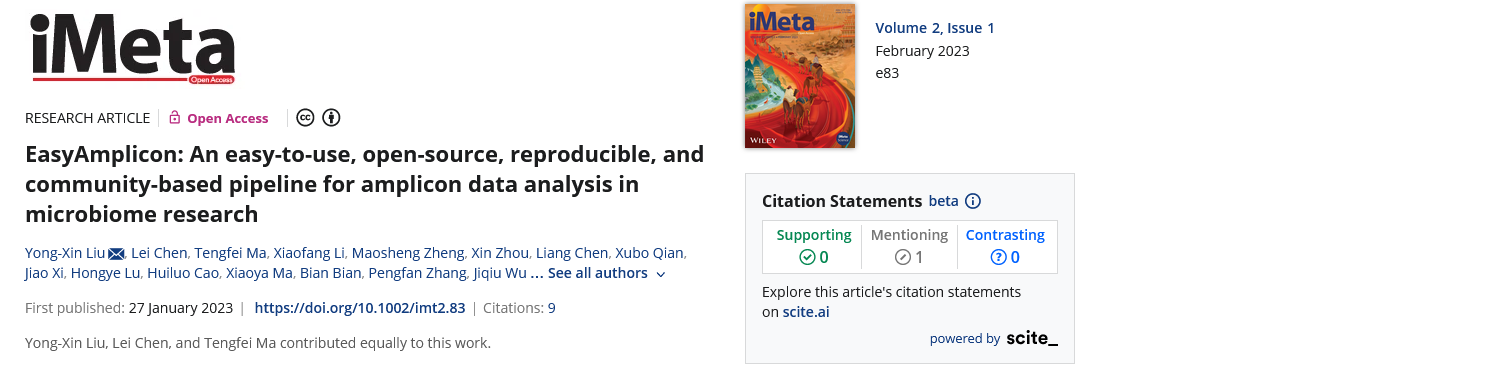


https://onlinelibrary.wiley.com/doi/10.1002/imt2.83

In [ ]:
import os, re, gzip, json
import pandas as pd
from pandas import DataFrame
from functools import reduce

In [ ]:
def decompress(infile, tofile):
    """
    ejemplo
    decompress('file.fastq.gz', 'file.fastq')
    """
    with open(infile, 'rb') as inf, open(tofile, 'w', encoding='utf8') as tof:
        decom_str = gzip.decompress(inf.read()).decode('utf-8')
        tof.write(decom_str)


Antes de comenzar todo, configurar el directorio con los programas binarios en las variables de entorno  

En este caso la ruta es:  

C:\Users\pgen1\Documents\Azaola\marco\binarios  

flash  
vsearch  
usearch   


#### editar los nombres de los archivos

In [ ]:
fastqfiles = [i for i in os.listdir('../AzaolaV3V4/') if '.fastq' in i]
fastqfiles = [i for i in fastqfiles if 'M_' in i]
fastqfiles

In [ ]:
new_fastqfiles = []
for d in fastqfiles:
    print(d, re.sub('_S\d+_L001|_001', '', d).split('.gz')[0])
    #decompress('../AzaolaV3V4/'+d, re.sub('_S\d+_L001|_001', '', d).split('.gz')[0])
    new_fastqfiles.append(re.sub('_S\d+_L001|_001', '', d).split('.gz')[0])

#### ordenar los archivos por numero

In [ ]:
nums = list(set([int(re.search('\d+', i.split('_')[0]).group()) for i in new_fastqfiles]))
ordenado = []
for n in nums:
    for i in new_fastqfiles:
        m = int(re.search('\d+', i.split('_')[0]).group())
        if n == m:
            ordenado.append(i)

In [ ]:
ordenado

#### Renombrar los encabezados de cada secuencia dentro de los archivos fastq

In [ ]:
folder = 'fastq16S'
os.makedirs(folder, exist_ok = True)

In [ ]:
for i in ordenado:
    index = re.sub('\d+-|_R.*', '', i)
    file = i
    
    print(index, '>>>', file)
    
    with open(folder+'/'+i, 'w') as w:
        with open(file, 'r') as handle:
            conteo = 1
            m = 0
            for line in handle:
                #line = re.sub('\n$', '', line)
                if m < 4:
                    pass
                else:
                    m = 0
                if m == 0:
                    nuevo = re.sub('^@.*', '@'+index+'.'+str(conteo), line)
                    w.write(nuevo)
                    conteo += 1
                if m == 1:
                    w.write(line)
                if m == 2:
                    w.write(line)
                if m == 3:
                    w.write(line)
                m +=1

#### Revisa si las longitudes de los reads son menores a 200 nt

In [ ]:
ll = []
ww = []
for f in os.listdir(folder):
    with open(f, 'r') as fq:
        for i in fq:
            i = i.rstrip()
            if set(i) == set('ACTG'):
                if len(i) < 200:
                    ll.append(len(i))
                else:
                    ww.append(len(i))
print(len(ll), set(ll))

In [ ]:
print(len(ww), set(ww))

In [ ]:
VV = int(round(max(set(ww)) * 0.9, 0))
VV

In [ ]:
int(max(set(ww)))

#### Archivos pareados

In [ ]:
pareados = []
for i in [i for i in ordenado if 'R1' in i]:
    for j in [i for i in os.listdir() if '_R2' in i]:
        if re.sub('_R.', '', i) == re.sub('_R.', '', j):
            pareados.append([i, j])

In [ ]:
pareados

In [ ]:
set(['ACTG'])

### Remove primers using cutadapt

In [ ]:
F314 = 'CCTACGGGNGGCWGCAG' # W = 	A,T    N =  	A,C,G,T 
R805 = 'GACTACHVGGGTATCTAATCC' # H = 	A,C,T       V =  	A,C,G     
print(F314, R805)
print(len(F314), len(R805))

In [ ]:
fol_trimm = 'trimm'
os.makedirs(fol_trimm,exist_ok = True)

In [ ]:
for r1, r2 in pareados:
    comando = 'cutadapt -g '+F314+' -G '+R805+' --quality-cutoff 25,20 --minimum-length '+str(VV)+' --discard-untrimmed -o '+fol_trimm+'/t_'+r1+' -p '+fol_trimm+'/t_'+r2+\
    ' '+folder+'/'+r1+' '+folder+'/'+r2+' --json '+fol_trimm+'/report#'+r1.split('.')[0]+'.json'
    print(r1, r2)
    os.system("start /wait /min cmd /c "+comando)

In [ ]:
print(comando)

In [ ]:
reporte = {}
for x in [i for i in os.listdir(fol_trimm) if 'report' in i]:
    f = open(fol_trimm+'/'+x)
    data = json.load(f)
    f.close()
    ini, fin = data['read_counts']['input'], data['read_counts']['output']
    reporte[x.split('#')[1].split('.')[0]] = [ini, fin, round((fin / ini) * 100, 2)]

In [ ]:
reporte

### Merge (assembly) sequences using flash

In [ ]:
fol_assembly = 'assembly'
os.makedirs(fol_assembly, exist_ok = True)

In [ ]:
merge_seq = []
for r1, r2 in pareados:
    r1, r2 = 't_'+r1, 't_'+r2
    fr1, fr2 = fol_trimm+'/'+r1, fol_trimm+'/'+r2
    out = r1.split('_')[1]
    merge_seq.append(out)
    print(r1, r2, '▶', out)
    os.system('start /wait /min cmd /c flash '+fr1+' '+fr2+' -q -m 20 -M 200 -x 0.2 -t 4 -o '+fol_assembly+'/'+out)
    os.rename(fol_assembly+'/'+out+'.extendedFrags.fastq', fol_assembly+'/'+out+'.fastq')
    removidos = [os.remove(fol_assembly+'/'+out+i) for i in ['.hist', '.histogram', '.notCombined_1.fastq', '.notCombined_2.fastq']]

In [ ]:
merge_seq

####  <font color = red>Construccion y longitud promedio de la region V3-V4 dentro de la base de datos, esta se usa como referencia para eliminar chimeras</font>

In [ ]:
def open_file(file = ''):
    fas = {}
    with open(file) as fq:
        for line in fq:
            line = line.rstrip()
            if '>' in line:
                header = line
                s = ''
            else:
                s += line
            fas[header] =  s
    return fas

In [ ]:
with open('dbs/V3-V4_rdp_silva.fasta', 'w') as fq:
    for k in ['rdp_16s_v18.fasta', 'ltp_16s_v123.fa']:
        fas = open_file(file = 'dbs/'+k)
        lon = []
        for i in fas:
            l = len(re.findall('CCTACGGG[ACGT]GGC[AT]GCAG.*GGATTAGATACCC[CGT][AGT]GTAGTC', fas[i]))
            if l > 0:
                sec = re.findall('CCTACGGG[ACGT]GGC[AT]GCAG.*GGATTAGATACCC[CGT][AGT]GTAGTC', fas[i])[0]
                lon.append(len(sec) - (len(F314) + len(R805)))
                fq.write(i+'\n'+sec+'\n')
        v3v4min, v3v4max = min(lon), max(lon)
        print(k, v3v4min, v3v4max)
        del fas

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
cc = 0
longitudes = []
with open('dbs/V3-V4_rdp_silva.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>.*', i):
            cc += 1
        else:
            longitudes.append(len(i.rstrip()) - (len(F314) + len(R805)))

In [ ]:
cc

In [ ]:
v3v4min, v3v4max = min(longitudes), max(longitudes)
print(v3v4min, v3v4max)

### Merge all samples into a single file

 <font color = red> !!! no abrir el archivo generado porque es demasiado pesado !!! </font>

In [ ]:
count = 0
with open(fol_assembly+'/all_merge_seq.fastq', 'w') as outfile:
    for fname in merge_seq:
        with open(fol_assembly+'/'+fname+'.fastq') as infile:
            for line in infile:
                outfile.write(line)
                count += 1
count = int(count/4)

 <font color = blue> ⏹ Conteo de secuencias fastq </font>

In [ ]:
count

### Filtrado y convercion de secuencias fastq a fasta usando vsearch

 <font color = red> !!! no abrir el archivo generado porque es demasiado pesado !!! </font>

In [ ]:
v3v4min, v3v4max

In [ ]:
# al no dar opciones en vsearch transforma todas las secuencias fastq a fasta
# se impuso un umbral en el tamaño de las secuencias --fastq_minlen 
os.system('start /wait cmd /k vsearch --fastx_filter '+fol_assembly+'/all_merge_seq.fastq --fastq_minlen '+str(v3v4min)+' --fastq_maxlen '+str(v3v4max)+' --fastaout '+fol_assembly+'/all_merge_seq.fasta')

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
count2 = 0
with open(fol_assembly+'/all_merge_seq.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>\d+M[.]\d+', i):
            count2 += 1
        else:
            pass

In [ ]:
count2

 <font color = marrown> ⏹ Secuencuas descartadas </font>

In [ ]:
print('Descartadas =', count - count2)

### Desreplicacion de secuencias usando vsearch

In [ ]:
# string para las secuencias
label = 'Uniq'

In [ ]:
# --minuniquesize 5 [abundancia minima remueve sinletones
os.system('start /wait cmd /c vsearch --derep_fulllength '+fol_assembly+'/all_merge_seq.fasta --minuniquesize 2 --sizeout --relabel '+label+' --output '\
          +fol_assembly+'/derep.fasta --log '+fol_assembly+'/derep.log')


 <font color = marrown> ⏹ Impresion de mensaje</font>

In [ ]:
with open(fol_assembly+'/derep.log') as fq:
    for i in fq:
        i = i.rstrip()
        print(i)

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
count3 = 0
with open(fol_assembly+'/derep.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>'+label+'\d+', i):
            count3 += 1
        else:
            pass

In [ ]:
count3

#### Ordenar las secuencias del paso anterior (es importante para que `usearch` pueda correr)

In [ ]:
os.system('start /wait cmd /k vsearch --sortbysize '+fol_assembly+'/derep.fasta --minsize 5 --output '+fol_assembly+'/derep_sorted.fasta')

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
count4 = 0
with open(fol_assembly+'/derep_sorted.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>'+label+'\d+', i):
            count4 += 1
        else:
            pass 

In [ ]:
count4

### Cluster OTUs using `usearch`

 ### <font color = limegreen> ⏹ OTUs</font>

In [ ]:
os.system('start /wait cmd /k usearch -cluster_otus '+fol_assembly+'/derep_sorted.fasta -minsize 5 -otus '+fol_assembly+'/usearch_otus.fasta -relabel OTU_')

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
ot = 0
with open(fol_assembly+'/usearch_otus.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>OTU_\d+', i):
            ot += 1
        else:
            pass

In [ ]:
ot

#### Perform reference-based chimera detection using vsearch

In [ ]:
os.system('start /wait cmd /c vsearch --uchime_ref '+fol_assembly+'/usearch_otus.fasta --db dbs/V3-V4_rdp_silva.fasta --sizein --nonchimeras '+
          fol_assembly+'/otus_ref.fasta --log '+fol_assembly+'/otus_ref.log')

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
count7 = 0
with open(fol_assembly+'/otus_ref.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>OTU_\d+', i):
            count7 += 1
        else:
            pass

In [ ]:
count7

 <font color = marrown> ⏹ Impresion de mensaje</font>

In [ ]:
with open(fol_assembly+'/otus_ref.log') as fq:
    for i in fq:
        i = i.rstrip()
        print(i)

### Mapping OTUs to initial sequence using vsearch
#### Creating a table of OTU abundance
Los otus fueron generados usando usearch

In [ ]:
os.system('start /wait cmd /k vsearch --usearch_global '+fol_assembly+'/all_merge_seq.fasta --db '+fol_assembly+'/otus_ref.fasta -strand plus --id 0.97 --threads 6 --sizeout '\
          '--otutabout '+fol_assembly+'/otu_frequency_table.txt -uc '+fol_assembly+'/otu_map.uc')

In [ ]:
pd.set_option('max_columns', 35)

In [ ]:
df = pd.read_csv(fol_assembly+'/otu_frequency_table.txt', sep = '\t')

In [ ]:
df

### Assigning taxonomy to OTU sequences
#### Species annotation, and/or removal of plastids and non-bacteria

In [ ]:
os.system('start /wait cmd /c vsearch --sintax '+fol_assembly+'/otus_ref.fasta --db dbs/rdp_16s_v18.fasta --tabbedout '+fol_assembly+'/otus_tax.sintax --sintax_cutoff 0.8')

In [ ]:
os.system('start /wait cmd /k usearch -sintax '+fol_assembly+'/otus_ref.fasta -db dbs/rdp_16s_v18.fasta -tabbedout '+fol_assembly+'/reads.sintax -strand both -sintax_cutoff 0.8')

In [ ]:
recording = []
tax = {}
with open(fol_assembly+'/reads.sintax', 'r') as fq:
    for i in fq:
        i = i.rstrip()
        if (len(i.split('\t')) == 1) or ('Chloroplast' in i) or ('Mitochondria' in i) or ('Eukaryota' in i):
            pass
        else:
            recording.append(i.split('\t')[0])
            tax[i.split('\t')[0]] = [i.split('\t')[1], re.sub('[(][0-9.]{1,50}[)]', '', i.split('\t')[1]), i.split('\t')[2], i.split('\t')[3]]

In [ ]:
rec = DataFrame(list(set(recording) & set(df['#OTU ID'])), columns = ['#OTU ID'])

In [ ]:
otutab_txt = rec.merge(df, on = ['#OTU ID'], how = 'left')
otutab_txt['#otu'] = [int(i.split('_')[1]) for i in otutab_txt['#OTU ID']]
otutab_txt = otutab_txt.sort_values(by =['#otu'],ascending=True).reset_index(drop=True)
otutab_txt['#sum'] = otutab_txt.values[:, 1:-1].sum(axis = 1)

In [ ]:
otutab_txt

#### Depuracion de tabla a un minimo de 5 reads por OTU

In [ ]:
MINREADS = 5 # otus con menos de 5 lecturas son descartados

In [ ]:
abundancias = []
for i in otutab_txt.columns[1:-2]:
    t = otutab_txt[otutab_txt[i] >= MINREADS][['#OTU ID', i]].sort_values(by = i, ascending = False).reset_index(drop = True)
    abundancias.append(t)
tt = reduce(lambda  left, right: pd.merge(left, right, on = ['#OTU ID'], how = 'outer'), abundancias).fillna(0)
for i in otutab_txt.columns[1:-2]: # las columnas con numeros flotantes los hace enteros
        tt[i] = tt[i].astype('int')

In [ ]:
tt

In [ ]:
tax

In [ ]:
tax['OTU_462']

In [ ]:
tax['OTU_466']

In [ ]:
tax['OTU_462']

In [ ]:
tax['OTU_466']

In [ ]:
taxa = DataFrame([[i, tax[i][0], tax[i][1], tax[i][3]] for i in tax], columns = ['#OTU ID', 'valTax', 'allTax', 'cutTax'])

In [ ]:
taxa[taxa['#OTU ID'] == 'OTU_3948']

In [ ]:
taxa

In [ ]:
pd.pivot_table(taxa[['#OTU ID', 'allTax']], values = ['#OTU ID'], index = ['allTax'], aggfunc = sum).reset_index()

In [ ]:
pd.pivot_table(taxa[['#OTU ID', 'cutTax']], values = ['#OTU ID'], index = ['cutTax'], aggfunc = len).sort_values(by = '#OTU ID', ascending = False).reset_index()

In [ ]:
taxa = DataFrame(tax, columns = ['#OTU ID', 'Tax'])
taxa

In [ ]:
for i in taxa[['Tax']].drop_duplicates()['Tax'].tolist():
    print(i)

In [ ]:
pd.pivot_table(taxa, values = ['#OTU ID'], index = ['Tax'], aggfunc = sum).reset_index()

### Filter the sequence corresponding to the new table

In [ ]:
# obtener un nuevo fasta a partir de los OTUs filtrados en el paso anterior

In [ ]:
tt[tt['#OTU ID'] == 'OTU_7916']

### Equalization of sampling

In [ ]:
d = pd.read_csv(fol_assembly+'/otutab.txt', sep = '\t')

In [ ]:
f = d[['1M']]
f[f['1M'] > 0].sort_values(by = '1M', ascending = False).reset_index(drop = True).head(50)

In [ ]:
d[['1M']].sort_values(by = '1M', ascending = False).reset_index(drop = True).head(50)

In [ ]:
dd = d[['28M']].sort_values(by = '28M', ascending = True).reset_index(drop = True)
dd = dd[dd['28M'] > 1]['28M']
dd

In [ ]:
dd.values

In [ ]:
np.cumsum(dd.values)

In [ ]:
for i, j in zip(dd.values, np.cumsum(dd.values)):
    print(i, j)

In [ ]:
h = pd.read_csv(fol_assembly+'/otutab_rare.txt', sep = '\t')
h

In [ ]:
col = 'X14M'

In [ ]:
w = h[h[col] > -1][[col]].sort_values(by = col, ascending = True).reset_index(drop = True)
w

In [ ]:
import numpy as np

In [ ]:
w[col].values

In [ ]:
np.cumsum(w[col].values)

In [ ]:
w[w[col].values == 1]

In [ ]:
for i, j in zip(w[col].values, np.cumsum(w[col].values)):
    print(i, j)

In [ ]:
len(w[col].values)

In [ ]:
pd.read_csv(fol_assembly+'/vegan.txt', sep = '\t')

In [ ]:
import numpy as np
from numpy.random import RandomState
def rarefaction(M, seed=0):
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=1) # number of occurrences for each sample
    nvar = M.shape[1] # number of variables
    depth = np.min(noccur) # sampling depth
    Mrarefied = np.empty_like(M)
    for i in range(M.shape[0]): # for each sample
        p = M[i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[i] = np.bincount(choice, minlength=nvar)
    return Mrarefied

In [ ]:
M = np.array([[0, 9, 0], [0, 3, 3], [0, 4, 4]])

In [ ]:
rarefaction(M)

 ### <font color = limegreen> ⏹ ASVs</font>

In [ ]:
os.system('start /wait cmd /c usearch -unoise3 '+fol_assembly+'/derep_sorted.fasta -minsize 5 -zotus '+fol_assembly+'/usearch_asvs.fasta')

 <font color = blue> ⏹ Conteo de secuencias fasta </font>

In [ ]:
asv = 0
with open(fol_assembly+'/usearch_asvs.fasta', 'r') as fq:
    for i in fq:
        if re.search('^>.*\d+', i):
            asv += 1
        else:
            pass

In [ ]:
asv

In [ ]:
import numpy as np
from pandas import DataFrame
from scipy.special import comb
import matplotlib.pyplot as plt

In [ ]:
def rarefy(x, method='rarefy', size = None, breakNA=True):
    '''
    Docstring for function ecopy.rarefy
    ========================
    Various rarefaction techniques for a site x species matrix.
        All indices computed along rows (axis = 1)

    Use
    ----
    rarefy(x, method='rarefy', size=None, breakNA=True)

    Parameters
    ----------
    x:  numpy array or pandas dataframe with observations as rows
        and descriptors as columns
    method: a method used for rarefaction
        rarefy: Calculates estimated richness rarified to a given sample 
            size (see size parameter).
            sum(1 - nCr(N-Ni, size) / (nCr(N, size)))
        rareCurve: Draws a rarefaction curve for each site (row). 
            Rarefaction curves use the following functoin
            Sn - sum(1 - nCr(N-Ni, i))/nCr(N, i)
            
    size: the sample size used in rarefaction. Can be left empty,
        in which case size is the minimum of row sums (number of 
        individuals from the sparsest site). Can be a single number, which applies
        the same size to all rows. Can be a numpy array that contains 
        different sizes for each site.
    breakNA: should the process halt if the matrix contains any NAs?
        if False, then NA's undergo pairwise deletion during distance calculation,
        such that when calculating the distance between two rows, if any
        species is missing from a row, that species is removed from both rows

    Example
    --------
    import ecopy as ep
    BCI = ep.load_data('BCI')
    
    # calculate rarefied species richness
    rareRich = ep.rarefy(BCI, 'rarefy')

    # draw rarefaction curves
    ep.rarefy(BCI, 'rarecurve')
    '''
    listofmethods = ['rarefy', 'rarecurve']
    if not isinstance(breakNA, bool):
        msg = 'removaNA argument must be boolean'
        raise ValueError(msg)
    if method not in listofmethods:
        msg = 'method argument {0!s} is not an accepted rarefaction method'.format(method)
        raise ValueError(msg)
    if not isinstance(x, (DataFrame, np.ndarray)):
        msg = 'x argument must be a numpy array or pandas dataframe'
        raise ValueError(msg)
    if size is not None:
        if not isinstance(size, (int, float, np.ndarray)):
            msg = 'size must be integer, float, or numpy array'
            raise ValueError(msg)
    if isinstance(x, DataFrame):
        if (x.dtypes == 'object').any():
            msg = 'DataFrame can only contain numeric values'
        if breakNA:
            if x.isnull().any().any():
                msg = 'DataFrame contains null values'
                raise ValueError(msg)
        if (x<0).any().any():
            msg = 'DataFrame contains negative values'
            raise ValueError(msg)
        if method=='rarefy':
            if size is None:
                sums = x.apply(sum, axis=1)
                size = np.min(sums)
                rich = x.apply(rare, axis=1, args=(size,))
                return rich
            else:
                if isinstance(size, (int, float)):
                     rich = x.apply(rare, axis=1, args=(size,))
                     return rich
                else:
                    if len(size) != len(x):
                        msg = 'length of size does not match number of rows'
                        raise ValueError(msg)
                    z = x.copy()
                    z['size'] = size
                    rich = z.apply(rare_wrapper, axis=1)
                    return rich
        if method=='rarecurve':
            z = x.copy()
            z.reset_index(inplace=True)
            z.apply(rCurve, axis=1)
            plt.xlabel('Number of Individuals')
            plt.ylabel('Number of Species')
            plt.show()
    if isinstance(x, np.ndarray):
        if breakNA:
            if np.isnan(np.sum(x)):
                msg = 'Array contains null values'
                raise ValueError(msg)
        if (x < 0).any():
            msg = 'Array contains negative values'
            raise ValueError(msg)
        if method=='rarefy':
            if size is None:
                sums = np.apply_along_axis(np.nansum, 1, x)
                size = np.min(sums)
                rich = np.apply_along_axis(rare, 1, x, size)
                return rich
            else:
                if isinstance(size, (int, float)):
                    rich = np.apply_along_axis(rare, 1, x, size)
                    return rich
                else:
                    if len(size) != x.shape[0]:
                        msg = 'length of size does not match number of rows'
                        raise ValueError(msg)
                    N = np.nansum(x, axis=1)
                    diff = (N[:,np.newaxis] - x).T
                    return np.sum(1 - comb(diff, size)/comb(N, size), axis=0)
        if method=='rarecurve':
            z = DataFrame(x)
            z.reset_index(inplace=True)
            z.apply(rCurve, axis=1)
            plt.xlabel('Number of Individuals')
            plt.ylabel('Number of Species')
            plt.show()

def rare(y, size):
    notabs = ~np.isnan(y)
    t = y[notabs]
    N = np.sum(t)
    diff = N - t
    rare_calc = np.sum(1 - comb(diff, size)/comb(N, size))
    return rare_calc

def rare_wrapper(data):
    s2 = data['size']
    x2 = data.drop('size')
    return rare(x2, s2)

def rareCurve_Func(i, Sn, n, x):
    sBar = Sn -  np.sum(comb(n-x, i))/comb(n, i) 
    return sBar

def rCurve(x):
    ix = x['index']
    z = x.drop('index').astype('float')
    notabs = ~np.isnan(z)
    y = z[notabs]
    n = np.sum(y)
    Sn = len(z)
    iPred = np.linspace(0, n, 1000)
    yhat = [rareCurve_Func(i, Sn, n, y) for i in iPred]
    plt.plot(iPred, yhat)
    plt.text(iPred[-1], yhat[-1], str(ix), ha='left', va='center')

In [ ]:
rarefy(d.values[:, 1:], method='rarefy', size = 10000, breakNA=True)

In [ ]:
d.dropna()

In [ ]:
d.values[:, 1:]

In [ ]:
h